In [1]:
import pandas as pd
import numpy as np
import sqlite3
import itertools
import pickle
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import MinMaxScaler, StandardScaler

pd.set_option('display.max_columns', 1000)

In [2]:
conn = sqlite3.connect('./database/database.sqlite')

# 1. EDA

In [3]:
pd.read_sql('SELECT * FROM sqlite_master where type="table"', conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [4]:
matches_df = pd.read_sql('SELECT * FROM Match', conn)
players_df = pd.read_sql('SELECT * FROM Player', conn)
leagues_df = pd.read_sql('SELECT * FROM League', conn)
country_df = pd.read_sql('SELECT * FROM Country', conn)
team_df = pd.read_sql('SELECT * FROM Team', conn)
team_attributes_df = pd.read_sql('SELECT * FROM Team_Attributes', conn)
player_attributes_df = pd.read_sql('SELECT * FROM Player_Attributes', conn)

## How many total matches are there?

In [5]:
matches_df.shape

(25979, 115)

### What are the earliest matches we have?

In [6]:
matches_df.sort_values(by='date', ascending=True).iloc[0:5, :]

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
24558,24559,24558,24558,2008/2009,1,2008-07-18 00:00:00,486263,10192,9931,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24559,24560,24558,24558,2008/2009,1,2008-07-19 00:00:00,486264,9930,10179,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24560,24561,24558,24558,2008/2009,1,2008-07-20 00:00:00,486265,10199,9824,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24561,24562,24558,24558,2008/2009,1,2008-07-20 00:00:00,486266,7955,10243,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24613,24614,24558,24558,2008/2009,2,2008-07-23 00:00:00,486268,6493,7955,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Is there enough player data per match? Print a dataframe showing the number of missing rows per column

In [7]:
# matches_df = matches_df.dropna(subset=[f'home_player_{i}' for i in range(1, 12)], axis=0)
# matches_df = matches_df.dropna(subset=[f'away_player_{i}' for i in range(1, 12)], axis=0)

matches_df = matches_df.iloc[:, :-30] # remove betting features

dic = dict(zip(matches_df.columns, matches_df.isna().sum()))
na_df = pd.DataFrame([dic])
na_df

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
0,0,0,0,0,0,0,0,0,0,0,0,1821,1821,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1833,1833,1839,1821,1821,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1833,1833,1839,1224,1315,1281,1323,1316,1325,1227,1309,1273,1436,1555,1234,1278,1293,1321,1335,1313,1235,1341,1328,1441,1554,11762,11762,11762,11762,11762,11762,11762,11762


### Merge matches dataframe with team attributes frame by team ID and season

In [8]:
def get_season(date):
    year, month = date.split('-')[0], date.split('-')[1]
    # typical season runs from august to may
    if (int(month) < 8):
        return f'{int(year)-1}/{year}'
    return f'{year}/{int(year)+1}'

team_attributes_df['season_new'] = team_attributes_df['date'].apply(get_season)
team_attributes_df = team_attributes_df.drop('date', axis=1)
# There are duplicate seasons for some players
matches_df = matches_df.merge(team_attributes_df, left_on=['home_team_api_id','season'], right_on = ['team_api_id','season_new'], how='left')
matches_df = matches_df.merge(team_attributes_df, left_on=['away_team_api_id','season'], right_on = ['team_api_id','season_new'], how='left')
# matches_df = matches_df.drop(['home_team_api_id', 'team_api_id', 'match_id', 'date', 'match_api_id', 'away_team_api_id'])
matches_df.head()

,id_x,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,id_y,team_fifa_api_id_x,team_api_id_x,buildUpPlaySpeed_x,buildUpPlaySpeedClass_x,buildUpPlayDribbling_x,buildUpPlayDribblingClass_x,buildUpPlayPassing_x,buildUpPlayPassingClass_x,buildUpPlayPositioningClass_x,chanceCreationPassing_x,chanceCreationPassingClass_x,chanceCreationCrossing_x,chanceCreationCrossingClass_x,chanceCreationShooting_x,chanceCreationShootingClass_x,chanceCreationPositioningClass_x,defencePressure_x,defencePressureClass_x,defenceAggression_x,defenceAggressionClass_x,defenceTeamWidth_x,defenceTeamWidthClass_x,defenceDefenderLineClass_x,season_new_x,id,team_fifa_api_id_y,team_api_id_y,buildUpPlaySpeed_y,buildUpPlaySpeedClass_y,buildUpPlayDribbling_y,buildUpPlayDribblingClass_y,buildUpPlayPassing_y,buildUpPlayPassingClass_y,buildUpPlayPositioningClass_y,chanceCreationPassing_y,chanceCreationPassingClass_y,chanceCreationCrossing_y,chanceCreationCrossingClass_y,chanceCreationShooting_y,chanceCreationShootingClass_y,chanceCreationPositioningClass_y,defencePressure_y,defencePressureClass_y,defenceAggression_y,defenceAggressionClass_y,defenceTeamWidth_y,defenceTeamWidthClass_y,defenceDefenderLineClass_y,season_new_y
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [9]:
player_attributes_df.shape

(183978, 42)

### Merge matches_df with player_attributes_df

In [10]:
player_attributes_df['season'] = player_attributes_df['date'].apply(get_season)
player_attributes_df.drop('date', axis=1, inplace=True)
player_attributes_df = player_attributes_df.drop_duplicates(subset=['player_api_id', 'season'])
for i in range(1, 12):
    matches_df = matches_df.merge(player_attributes_df, left_on=[f'home_player_{i}','season'], right_on = ['player_api_id','season'], how='left', suffixes=[None, f'_home_{i}'], validate='many_to_one')
#     print(matches_df.shape)

In [11]:
for i in range(1,12):
    matches_df = matches_df.merge(player_attributes_df, left_on=[f'away_player_{i}','season'], right_on = ['player_api_id','season'], how='left', suffixes=[None, f'_away_{i}'], validate='many_to_one')
#     print(matches_df.shape)

In [12]:
# rename player attribute columns to reflect the team
for col in matches_df.columns:
    if col in player_attributes_df.columns:
#         print(col)
        matches_df.rename(columns = {col:f'{col}_home_1'},inplace=True)

### Remove all columns that have over 30% of null cells

In [13]:
dic = dict(matches_df.isna().sum())
for key in dic:
    if (dic[key] / len(matches_df) > 0.3).any():
        matches_df = matches_df.drop(key, axis=1)
matches_df.shape

(25979, 1027)

## Mean and Mode Imputation

### Impute team attributes with the mean of the column

In [14]:
num_cols = matches_df.select_dtypes(include=['int','float', 'float64']).columns
cat_cols = [x for x in matches_df.columns if x not in num_cols]
for col in num_cols:
    if col[0:-2] in team_attributes_df.columns and col.find('_x') != -1:
        matches_df[col] = matches_df[col].fillna(matches_df.groupby('home_team_api_id')[col].transform('mean'))
    elif col[0:-2] in team_attributes_df.columns and '_y' in col:
        matches_df[col] = matches_df[col].fillna(matches_df.groupby('away_team_api_id')[col].transform('mean'))

### Drop categorical team attributes

In [15]:
for col in cat_cols:
    if col[0:-2] in team_attributes_df.columns:
        matches_df = matches_df.drop(col,axis=1)
matches_df.shape        
# for col in cat_cols:
#     matches_df[col] = matches_df[col].astype('category').cat.codes
# matches_df.head()

(25979, 1001)

In [16]:
matches_df.head()

,id_x,country_id,league_id,season_home_1,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,id_y,team_fifa_api_id_x,team_api_id_x,buildUpPlaySpeed_x,buildUpPlayPassing_x,chanceCreationPassing_x,chanceCreationCrossing_x,chanceCreationShooting_x,defencePressure_x,defenceAggression_x,defenceTeamWidth_x,id_home_1,team_fifa_api_id_y,team_api_id_y,buildUpPlaySpeed_y,buildUpPlayPassing_y,chanceCreationPassing_y,chanceCreationCrossing_y,chanceCreationShooting_y,defencePressure_y,defenceAggression_y,defenceTeamWidth_y,id_home_1,player_fifa_api_id_home_1,player_api_id_home_1,overall_rating_home_1,potential_home_1,preferred_foot_home_1,attacking_work_rate_home_1,defensive_work_rate_home_1,crossing_home_1,finishing_home_1,heading_accuracy_home_1,short_passing_home_1,volleys_home_1,dribbling_home_1,curve_home_1,free_kick_accuracy_home_1,long_passing_home_1,ball_control_home_1,acceleration_home_1,sprint_speed_home_1,agility_home_1,reactions_home_1,balance_home_1,shot_power_home_1,jumping_home_1,stamina_home_1,strength_home_1,long_shots_home_1,aggression_home_1,interceptions_home_1,positioning_home_1,vision_home_1,penalties_home_1,marking_home_1,standing_tackle_home_1,sliding_tackle_home_1,gk_diving_home_1,gk_handling_home_1,gk_kicking_home_1,gk_positioning_home_1,gk_reflexes_home_1,id_home_2,player_fifa_api_id_home_2,player_api_id_home_2,overall_rating_home_2,potential_home_2,preferred_foot_home_2,attacking_work_rate_home_2,defensive_work_rate_home_2,crossing_home_2,finishing_home_2,heading_accuracy_home_2,short_passing_home_2,volleys_home_2,dribbling_home_2,curve_home_2,free_kick_accuracy_home_2,long_passing_home_2,ball_control_home_2,acceleration_home_2,sprint_speed_home_2,agility_home_2,reactions_home_2,balance_home_2,shot_power_home_2,jumping_home_2,stamina_home_2,strength_home_2,long_shots_home_2,aggression_home_2,interceptions_home_2,positioning_home_2,vision_home_2,penalties_home_2,marking_home_2,standing_tackle_home_2,sliding_tackle_home_2,gk_diving_home_2,gk_handling_home_2,gk_kicking_home_2,gk_positioning_home_2,gk_reflexes_home_2,id_home_3,player_fifa_api_id_home_3,player_api_id_home_3,overall_rating_home_3,potential_home_3,preferred_foot_home_3,attacking_work_rate_home_3,defensive_work_rate_home_3,crossing_home_3,finishing_home_3,heading_accuracy_home_3,short_passing_home_3,volleys_home_3,dribbling_home_3,curve_home_3,free_kick_accuracy_home_3,long_passing_home_3,ball_control_home_3,acceleration_home_3,sprint_speed_home_3,agility_home_3,reactions_home_3,balance_home_3,shot_power_home_3,jumping_home_3,stamina_home_3,strength_home_3,long_shots_home_3,aggression_home_3,interceptions_home_3,positioning_home_3,vision_home_3,penalties_home_3,marking_home_3,standing_tackle_home_3,sliding_tackle_home_3,gk_diving_home_3,gk_handling_home_3,gk_kicking_home_3,gk_positioning_home_3,gk_reflexes_home_3,id_home_4,player_fifa_api_id_home_4,player_api_id_home_4,overall_rating_home_4,potential_home_4,preferred_foot_home_4,attacking_work_rate_home_4,d

### Impute numerical player attributes

In [ ]:
num_cols = matches_df.select_dtypes(include=['int','float', 'float64']).columns
cat_cols = [x for x in matches_df.columns if x not in num_cols]

def impute_column(col, stage='home'):
    if (col[0:-7] in player_attributes_df.columns or col[0:-8] in player_attributes_df.columns) \
        and col.find(f'{stage}_') != -1:
        return True
    if ('_player_X' in col or '_player_Y' in col) and col.find(f'{stage}') != -1:
        return True
    return False

for col in num_cols:
    if impute_column(col, 'home'):
        for i in range(1, 12):
            matches_df[col] = matches_df[col].fillna(matches_df.groupby(f'home_player_{i}')[col].transform('mean'))
    elif impute_column(col, 'away'):
        for i in range(1, 12):
            matches_df[col] = matches_df[col].fillna(matches_df.groupby(f'away_player_{i}')[col].transform('mean'))
   
# f = lambda x: x.median() if np.issubdtype(x.dtype, np.number) else x.mode()

# for col in cat_cols:
#     matches_df[col] = matches_df[col].astype('category').cat.codes
# matches_df.head()

### Impute categorical player attributes

In [ ]:
f = lambda x: x.mode().iloc[0] if len(x.mode())>0 else np.NaN
for col in cat_cols:
    if impute_column(col, 'home'):
        for i in range(1, 12):
            matches_df[col] = matches_df[col].fillna(matches_df.groupby(f'home_player_{i}')[col].transform(f))
    elif impute_column(col, 'away'):
        for i in range(1, 12):
            matches_df[col] = matches_df[col].fillna(matches_df.groupby(f'away_player_{i}')[col].transform(f))

### Create a label column that reflects the scoreline

In [ ]:
matches_df['label'] = (matches_df['home_team_goal'] - matches_df['away_team_goal']).apply(np.sign)

In [ ]:
dict(matches_df.isna().sum())

## Iterative Imputer

In [44]:
# from sklearn.model_selection import train_test_split

# # matches_df['label'] = (matches_df['home_team_goal'] - matches_df['away_team_goal']).apply(np.sign)
# drop_cols = ['home_team_goal','away_team_goal','goal','date','shoton',
#              'shotoff','foulcommit','card','cross','corner','possession',
#              'match_api_id', 'season_new_x', 'id', 'season_new_y', 'id_y',
#              'team_api_id_x', 'team_fifa_api_id_x', 'team_fifa_api_id_y',
#              'team_api_id_y', 'id_x', 'home_team_api_id', 'date_x', 'date_y']

# matches_df.drop(drop_cols, inplace=True, axis=1, errors='ignore')
# player_ids = [f'home_player_{i}' for i in range(1, 12)] + [f'away_player_{i}' for i in range(1, 12)]
# matches_df.drop(player_ids, inplace=True, axis=1,errors='ignore')

# # matches_df['season'] = matches_df['season'].astype('category').cat.codes

# num_cols = matches_df.select_dtypes(include=['int','float', 'float64']).columns
# cat_cols = [x for x in matches_df.columns if x not in num_cols]
# for col in cat_cols:
#     matches_df[col] = matches_df[col].astype('category').cat.codes

X = matches_df.iloc[:,:-1]
y = matches_df.iloc[:,-1]
y.replace({-1:2,1:1,0:0},inplace=True)

(array([ 184., 1167., 1444., 2139., 4654., 6041., 4092., 3687., 1858.,
         266.]),
 array([20., 26., 32., 38., 44., 50., 56., 62., 68., 74., 80.]),
 <BarContainer object of 10 artists>)

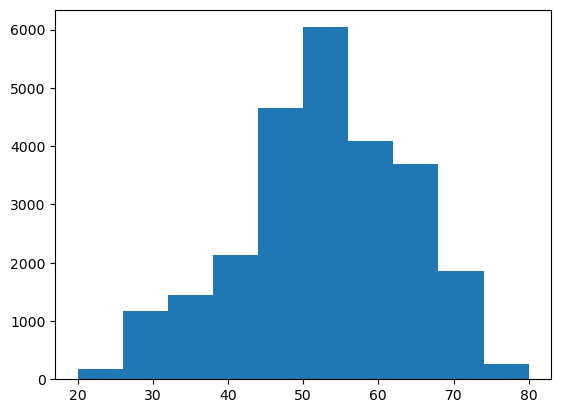

In [41]:
plt.hist(X['buildUpPlaySpeed_x'],bins=10)

In [ ]:
imp = IterativeImputer(max_iter=10, random_state=0)
num_cols = matches_df.select_dtypes(include=['int','float', 'float64']).columns.to_list()
num_cols.remove('label')

X_new_itr = imp.fit_transform(X[num_cols])
X[num_cols] = X_new_itr
X_train, X_test, y_train, y_test = train_test_split(X_new_itr,y, test_size=0.2,random_state=0)

In [36]:
pd.DataFrame(X_new_itr).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1.0,778.590909,673.000000,9987.000000,56.148649,45.608108,53.445946,53.445946,55.743243,49.324324,51.621622,60.675676,675.0,9993.0,45.909091,42.500000,48.750000,50.227273,55.454545,48.863636,49.545455,55.681818
1,2.0,763.857143,15005.000000,10000.000000,55.675676,52.905405,50.472973,48.918919,43.310811,49.324324,55.743243,49.729730,2007.0,9994.0,63.445946,53.716216,46.554054,47.297297,55.270270,49.391892,55.675676,56.013514
2,3.0,814.785714,1750.000000,9984.000000,54.152542,45.677966,61.610169,59.237288,50.932203,60.677966,50.847458,65.932203,229.0,8635.0,51.216216,46.148649,62.500000,52.635135,52.094595,59.459459,48.581081,63.513514
3,4.0,725.266667,674.000000,9991.000000,54.610390,47.545455,46.870130,64.649351,45.545455,51.623377,49.532468,46.623377,1747.0,9998.0,50.000000,50.000000,55.000000,48.000000,46.000000,46.000000,45.000000,47.000000
4,5.0,729.714286,11040.305474,10190.388774,57.951309,52.055728,52.037131,55.331118,54.008686,49.202110,54.268777,53.614124,232.0,9985.0,60.905405,60.270270,54.594595,59.054054,61.554054,52.567568,56.824324,57.297297


(array([ 184., 1167., 1444., 2139., 4654., 6041., 4092., 3687., 1858.,
         266.]),
 array([20., 26., 32., 38., 44., 50., 56., 62., 68., 74., 80.]),
 <BarContainer object of 10 artists>)

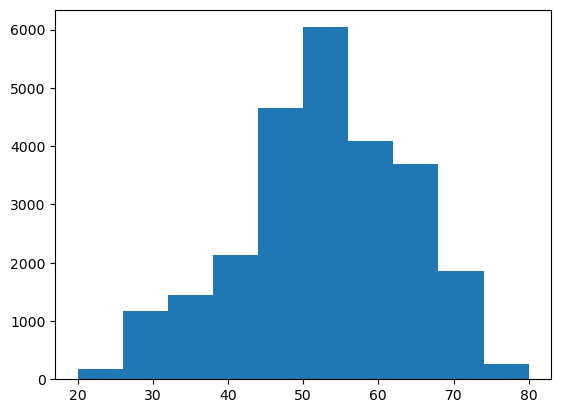

In [53]:
plt.hist(X['buildUpPlaySpeed_x'],bins=10)

### Save partially imputed data

In [21]:
matches_df.to_csv('./database/data_partially_imputed.csv',index=False)

## Feature Engineering

### 1. Create a head-to-head stat

In [21]:
matches_df['label'] = (matches_df['home_team_goal'] - matches_df['away_team_goal']).apply(np.sign).replace({-1: 0})
matches_df = matches_df.sort_values(by='date')
matches_df['head-to-head-wins'] = matches_df.groupby(['home_team_api_id', 'away_team_api_id'])['label'].cumsum()
matches_df['head-to-head-wins'] -= matches_df['label']

In [22]:
matches_df['label'] = (matches_df['home_team_goal'] - matches_df['away_team_goal']).apply(np.sign).replace({1: 0, -1:1})
matches_df = matches_df.sort_values(by='date')
matches_df['head-to-head-losses'] = matches_df.groupby(['home_team_api_id', 'away_team_api_id'])['label'].cumsum()
matches_df['head-to-head-losses'] -= matches_df['label']

In [23]:
matches_df['label'] = (matches_df['home_team_goal'] - matches_df['away_team_goal']).apply(np.sign).replace({1: 0, 0:1, -1:0})
matches_df = matches_df.sort_values(by='date')
matches_df['head-to-head-draws'] = matches_df.groupby(['home_team_api_id', 'away_team_api_id'])['label'].cumsum()
matches_df['head-to-head-draws'] -= matches_df['label']

### 2. Create last 5 games stat for both teams

In [ ]:
matches_df['label'] = (matches_df['home_team_goal'] - matches_df['away_team_goal']).apply(np.sign) 

matches_df[['T-1_home', 'T-2_home', 'T-3_home', 'T-4_home', 'T-5_home']] = 3 # 3 means stat is not available
matches_df[['T-1_away', 'T-2_away', 'T-3_away', 'T-4_away', 'T-5_away']] = 3
result_map = { -1: 2, 0: 0, 1: 1 } # stats need to be >= 0 for variance threshold feature selection

matches_df = matches_df.sort_values(by=['home_team_api_id', 'date']).reset_index(drop=True)
for row_idx, row_df in matches_df.iterrows():
    for i in range(1, 6):
        if row_idx - i > 0 and matches_df.loc[row_idx - i, 'home_team_api_id'] == row_df['home_team_api_id']:
            matches_df.loc[row_idx, f'T-{i}_home'] = result_map[matches_df.loc[row_idx - i, 'label']]
            
matches_df = matches_df.sort_values(by=['away_team_api_id', 'date']).reset_index(drop=True)
for row_idx, row_df in matches_df.iterrows():
    for i in range(1, 6):
        if row_idx - i > 0 and matches_df.loc[row_idx - i, 'away_team_api_id'] == row_df['away_team_api_id']:
            matches_df.loc[row_idx, f'T-{i}_away'] = result_map[matches_df.loc[row_idx - i, 'label']]
        

### 3. Save feature engineered data

In [25]:
matches_df['label'].replace(result_map, inplace=True)
matches_df.to_csv('./database/data_feature_engineered.csv',index=False)

/tmp/ipykernel_3754576/3156302207.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches_df['label'].replace(result_map, inplace=True)


### 4. See performance of XGBoost on Feature Engineered data

In [26]:
matches_df = pd.read_csv('./database/data_feature_engineered.csv')

In [27]:
drop_cols = ['home_team_goal','away_team_goal','goal','date','shoton',
             'shotoff','foulcommit','card','cross','corner','possession',
             'match_api_id', 'season_new_x', 'id', 'season_new_y', 'id_y',
             'team_api_id_x', 'team_fifa_api_id_x', 'team_fifa_api_id_y',
             'team_api_id_y', 'id_x', 'home_team_api_id', 'away_team_api_id', 
             'id_home_1']
matches_df.drop(drop_cols, inplace=True, axis=1, errors='ignore')
player_ids = [f'home_player_{i}' for i in range(1, 12)] + [f'away_player_{i}' for i in range(1, 12)]
matches_df.drop(player_ids, inplace=True, axis=1, errors='ignore')
matches_df.drop(['date_x','date_y'], inplace=True, axis=1, errors='ignore')
for col in matches_df.columns:
    if 'season' in col:
        matches_df[col] = matches_df[col].astype('category').cat.codes

In [28]:
num_cols = matches_df.select_dtypes(include=['int','float', 'float64']).columns
cat_cols = [x for x in matches_df.columns if x not in num_cols]
for col in cat_cols:
    matches_df[col] = matches_df[col].astype('category').cat.codes
    
matches_df.dropna(inplace=True)
matches_df.head()

,country_id,league_id,season_home_1,stage,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,buildUpPlaySpeed_x,buildUpPlayPassing_x,chanceCreationPassing_x,chanceCreationCrossing_x,chanceCreationShooting_x,defencePressure_x,defenceAggression_x,defenceTeamWidth_x,buildUpPlaySpeed_y,buildUpPlayPassing_y,chanceCreationPassing_y,chanceCreationCrossing_y,chanceCreationShooting_y,defencePressure_y,defenceAggression_y,defenceTeamWidth_y,id_home_1.1,player_fifa_api_id_home_1,player_api_id_home_1,overall_rating_home_1,potential_home_1,preferred_foot_home_1,attacking_work_rate_home_1,defensive_work_rate_home_1,crossing_home_1,finishing_home_1,heading_accuracy_home_1,short_passing_home_1,volleys_home_1,dribbling_home_1,curve_home_1,free_kick_accuracy_home_1,long_passing_home_1,ball_control_home_1,acceleration_home_1,sprint_speed_home_1,agility_home_1,reactions_home_1,balance_home_1,shot_power_home_1,jumping_home_1,stamina_home_1,strength_home_1,long_shots_home_1,aggression_home_1,interceptions_home_1,positioning_home_1,vision_home_1,penalties_home_1,marking_home_1,standing_tackle_home_1,sliding_tackle_home_1,gk_diving_home_1,gk_handling_home_1,gk_kicking_home_1,gk_positioning_home_1,gk_reflexes_home_1,id_home_2,player_fifa_api_id_home_2,player_api_id_home_2,overall_rating_home_2,potential_home_2,preferred_foot_home_2,attacking_work_rate_home_2,defensive_work_rate_home_2,crossing_home_2,finishing_home_2,heading_accuracy_home_2,short_passing_home_2,volleys_home_2,dribbling_home_2,curve_home_2,free_kick_accuracy_home_2,long_passing_home_2,ball_control_home_2,acceleration_home_2,sprint_speed_home_2,agility_home_2,reactions_home_2,balance_home_2,shot_power_home_2,jumping_home_2,stamina_home_2,strength_home_2,long_shots_home_2,aggression_home_2,interceptions_home_2,positioning_home_2,vision_home_2,penalties_home_2,marking_home_2,standing_tackle_home_2,sliding_tackle_home_2,gk_diving_home_2,gk_handling_home_2,gk_kicking_home_2,gk_positioning_home_2,gk_reflexes_home_2,id_home_3,player_fifa_api_id_home_3,player_api_id_home_3,overall_rating_home_3,potential_home_3,preferred_foot_home_3,attacking_work_rate_home_3,defensive_work_rate_home_3,crossing_home_3,finishing_home_3,heading_accuracy_home_3,short_passing_home_3,volleys_home_3,dribbling_home_3,curve_home_3,free_kick_accuracy_home_3,long_passing_home_3,ball_control_home_3,acceleration_home_3,sprint_speed_home_3,agility_home_3,reactions_home_3,balance_home_3,shot_power_home_3,jumping_home_3,stamina_home_3,strength_home_3,long_shots_home_3,aggression_home_3,interceptions_home_3,positioning_home_3,vision_home_3,penalties_home_3,marking_home_3,standing_tackle_home_3,sliding_tackle_home_3,gk_diving_home_3,gk_handling_home_3,gk_kicking_home_3,gk_positioning_home_3,gk_reflexes_home_3,id_home_4,player_fifa_api_id_home_4,player_api_id_home_4,overall_rating_home_4,potential_home_4,preferred_foot_home_4,attacking_work_rate_home_4,defensive_work_rate_home_4,crossing_home_4,finishing_home_4,heading_accuracy_home_4,short_passing_home_4,volleys_home_4,dribbling_home_4,curve_home_4,free_kick_accuracy_home_4,long_passing_home_4,ball_control_home_4,acceleration_home_4,sprint_speed_home_4,agility_home_4,reactions_home_4,balance_home_4,shot_power_home_4,jumping_home_4,stamina_home_4,strength_home_4,long_shots_home_4,aggression_home_4,interceptions_home_4,positioning_home_4,vision_home_4,penalties_home_4,marki

In [29]:
def evaluate_model(X_train, X_test, y_train, y_test):
    model_xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                  colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
                  gamma=0, gpu_id=-1, importance_type=None,
                  interaction_constraints='', learning_rate=0.300000012,
                  max_delta_step=0, max_depth=2, min_child_weight=10, n_estimators=100, n_jobs=32,
                  num_parallel_tree=1, objective='multi:softprob', predictor='auto',
                  random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                  subsample=1.0, tree_method='exact', validate_parameters=1,
                  verbosity=1)
    model_xgb.fit(X_train,y_train)
    y_pred = model_xgb.predict(X_test)
    print(accuracy_score(y_pred, y_test))

In [30]:
matches_df['label'] = matches_df['label'].replace({-1: 2})
y = matches_df.loc[:, 'label']
X = matches_df.drop('label', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0)
evaluate_model(X_train, X_test, y_train, y_test)

0.5386917486105173


In [31]:
matches_df.to_csv('./database/data_partially_preprocessed.csv', index=False)

### PCA on partially processed data

In [9]:
matches_df = pd.read_csv('./database/data_partially_preprocessed.csv')
matches_df = matches_df[matches_df['season_home_1']>1]

In [10]:
y = matches_df.loc[:, 'label']
X = matches_df.drop(['label'], axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.80)

X_new = pca.fit_transform(X)

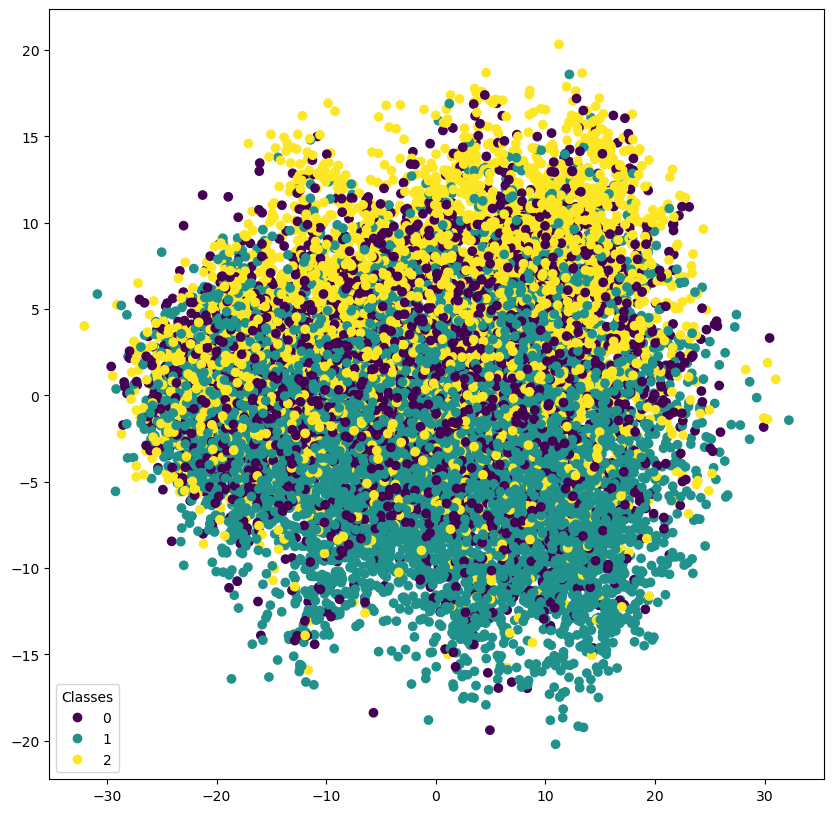

In [12]:
fig, ax = plt.subplots(figsize=(10,10))

scatter = ax.scatter(X_new[:,0],X_new[:,1], c=y)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
plt.savefig('./database/scatter.png')

## Feature Selection

In [32]:
matches_df=pd.read_csv('./database/data_partially_preprocessed.csv')

In [33]:
y = matches_df.loc[:, 'label']
X = matches_df.drop('label', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0)

### 1. Perform Variance-Threshold feature selection and see model performance

In [34]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(0.85 * (1 - 0.85))
X_new = sel.fit_transform(X)

In [35]:
# Observe the performance of Variance Threshold feature selection
X_train, X_test, y_train, y_test = train_test_split(X_new,y, test_size=0.2,random_state=0)
evaluate_model(X_train, X_test, y_train, y_test)

0.5386917486105173


### 2. Perform K-Best Feature Selection and see model performance

In [36]:
params = {'kbest__k': [4, 16, 32, 64, 128, 256, 512]}
model_xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                  colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
                  gamma=0, gpu_id=-1, importance_type=None,
                  interaction_constraints='', learning_rate=0.300000012,
                  max_delta_step=0, max_depth=2, min_child_weight=10, n_estimators=100, n_jobs=32,
                  num_parallel_tree=1, objective='multi:softprob', predictor='auto',
                  random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                  subsample=1.0, tree_method='exact', validate_parameters=1,
                  verbosity=1)
kbest = SelectKBest(chi2)
model = GridSearchCV(Pipeline([('kbest', kbest), ('xgb', model_xgb)]), param_grid=params, verbose=1, n_jobs=-1)
model.fit(X_train, y_train)
model.best_params_

Fitting 5 folds for each of 7 candidates, totalling 35 fits


{'kbest__k': 512}

In [37]:
# Observe the performance of K-Best feature selection
X_selected = SelectKBest(chi2, k=512).fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2,random_state=0)
evaluate_model(X_train, X_test, y_train, y_test)

0.5378366823428816


### 3. Fit a Random Forest Classifier and see the feature rankings

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
feature_names = X.columns
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)
importance = forest.feature_importances_
df = pd.DataFrame({'cols': X.columns, 'importance': importance}).sort_values(by='importance', ascending=False)
print(df.head(20))

                       cols  importance
313   overall_rating_home_7    0.002884
395   overall_rating_home_9    0.002773
190   overall_rating_home_4    0.002641
600   overall_rating_away_3    0.002621
805   overall_rating_away_8    0.002591
436  overall_rating_home_10    0.002480
641   overall_rating_away_4    0.002411
764   overall_rating_away_7    0.002409
220          marking_home_4    0.002289
723   overall_rating_away_6    0.002275
928  overall_rating_away_11    0.002179
272   overall_rating_home_6    0.002177
724        potential_away_6    0.002172
314        potential_home_7    0.002131
477  overall_rating_home_11    0.002083
221  standing_tackle_home_4    0.002030
454       reactions_home_10    0.001995
559   overall_rating_away_2    0.001972
149   overall_rating_home_3    0.001969
150        potential_home_3    0.001886


### 4. Boruta feature selection

In [39]:
matches_df = pd.read_csv('./database/data_feature_engineered.csv')
y = matches_df.loc[:, 'label']
X = matches_df.drop('label', axis=1)
# X = matches_df.iloc[:,:-1]
# y.replace({-1:2,1:1,0:0},inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0, stratify=y)

In [40]:
model_xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=2, min_child_weight=10, n_estimators=100, n_jobs=32,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1.0, tree_method='exact', validate_parameters=1,
              verbosity=1)

feat_selector = BorutaPy(
    verbose=2,
    estimator=model_xgb,
    n_estimators='auto',
    max_iter=10
)

# train Boruta
feat_selector.fit(np.array(X_train), np.array(y_train))

Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	979
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	979
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	979
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	979
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	979
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
Tentative: 	979
Rejected: 	0
Iteration: 	7 / 10
Confirmed: 	0
Tentative: 	979
Rejected: 	0
Iteration: 	8 / 10
Confirmed: 	0
Tentative: 	76
Rejected: 	903
Iteration: 	9 / 10
Confirmed: 	26
Tentative: 	50
Rejected: 	903


BorutaPy finished running.

Iteration: 	10 / 10
Confirmed: 	26
Tentative: 	15
Rejected: 	903


BorutaPy(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                 callbacks=None, colsample_bylevel=1,
                                 colsample_bynode=1, colsample_bytree=1,
                                 early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric=None,
                                 feature_types=None, gamma=0, gpu_id=-1,
                                 grow_policy='depthwise', importance_type=None,
                                 interaction_constraints='',
                                 learning_rate=0.300000012, max_bin=256,
                                 max_cat_threshold=64, max_cat_to_onehot=4,
                                 max_delta_step=0, max_depth=2, max_leaves=0,
                                 min_child_weight=10, missing=nan,
                                 monotone_constraints='()', n_estimators=616,
                                 n_jobs=32, num_parallel_tree=1,
                                 objective='multi:softprob', predictor='auto', ...),
         max_iter=10, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F031C0B2240, verbose=2)

In [41]:
# print support and ranking for each feature
print("\n------Support and Ranking for each feature------")
selected_cols = ['label']
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print("Passes the test: ", X.columns[i],
              " - Ranking: ", feat_selector.ranking_[i])
        selected_cols.append(X.columns[i])
    else:
        print("Doesn't pass the test: ",
              X.columns[i], " - Ranking: ", feat_selector.ranking_[i])
matches_df[selected_cols].to_csv('./database/data_selected.csv', index=False)


------Support and Ranking for each feature------
Doesn't pass the test:  country_id  - Ranking:  924
Doesn't pass the test:  league_id  - Ranking:  924
Doesn't pass the test:  season_home_1  - Ranking:  924
Doesn't pass the test:  stage  - Ranking:  439
Doesn't pass the test:  home_player_X1  - Ranking:  924
Doesn't pass the test:  home_player_X2  - Ranking:  855
Doesn't pass the test:  home_player_X3  - Ranking:  878
Doesn't pass the test:  home_player_X4  - Ranking:  879
Doesn't pass the test:  home_player_X5  - Ranking:  924
Doesn't pass the test:  home_player_X6  - Ranking:  589
Doesn't pass the test:  home_player_X7  - Ranking:  601
Doesn't pass the test:  home_player_X8  - Ranking:  888
Doesn't pass the test:  home_player_X9  - Ranking:  604
Doesn't pass the test:  home_player_X10  - Ranking:  872
Doesn't pass the test:  home_player_X11  - Ranking:  884
Doesn't pass the test:  away_player_X1  - Ranking:  924
Doesn't pass the test:  away_player_X2  - Ranking:  901
Doesn't pass th

In [43]:
X_filtered = feat_selector.transform(np.array(X))
print(f'Shape of selected features: {X_filtered.shape}')
X_train, X_test, y_train, y_test = train_test_split(X_filtered,y, test_size=0.2,random_state=0)
evaluate_model(X_train, X_test, y_train, y_test)

Shape of selected features: (23386, 26)
0.5412569474134246


In [42]:
selected_cols

['label',
 'potential_home_1',
 'overall_rating_home_3',
 'overall_rating_home_4',
 'overall_rating_home_5',
 'overall_rating_home_6',
 'potential_home_6',
 'overall_rating_home_7',
 'overall_rating_home_8',
 'overall_rating_home_9',
 'positioning_home_10',
 'overall_rating_home_11',
 'overall_rating_away_1',
 'overall_rating_away_2',
 'overall_rating_away_3',
 'potential_away_3',
 'overall_rating_away_4',
 'marking_away_4',
 'standing_tackle_away_4',
 'overall_rating_away_5',
 'overall_rating_away_6',
 'potential_away_6',
 'overall_rating_away_7',
 'overall_rating_away_8',
 'overall_rating_away_9',
 'overall_rating_away_11',
 'potential_away_11']

In [44]:
matches_df[selected_cols].to_csv('./database/data_selected_final.csv', index=False)

### 5. Fit an ExtraTreesClassifier and observe the feature importances

In [48]:
y = matches_df['label']
X = matches_df.drop('label', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_train, y_train)
clf.feature_importances_

array([9.71514818e-04, 9.68373774e-04, 7.80819967e-04, 1.07580829e-03,
       0.00000000e+00, 4.22422371e-04, 4.07068179e-04, 4.37567075e-04,
       4.80690901e-04, 8.55432877e-04, 7.78245040e-04, 8.70170503e-04,
       9.31128268e-04, 8.58377210e-04, 8.20715061e-04, 0.00000000e+00,
       4.20928987e-04, 3.98169871e-04, 4.15162088e-04, 4.01507593e-04,
       7.69638137e-04, 9.14714633e-04, 8.89599504e-04, 9.37352933e-04,
       7.99845697e-04, 9.50125248e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.46611709e-06, 4.02684454e-04, 9.18748723e-04,
       7.61345503e-04, 7.38995012e-04, 8.60819575e-04, 8.41307145e-04,
       8.19021760e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.53459853e-04, 7.40493097e-04, 7.85400298e-04,
       7.24896832e-04, 9.44300736e-04, 8.91321464e-04, 1.00019892e-03,
       1.01193422e-03, 1.13513391e-03, 9.81844580e-04, 1.11697505e-03,
       9.63635474e-04, 1.04226537e-03, 9.45632720e-04, 9.95555723e-04,
      

In [49]:
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2,random_state=0)
evaluate_model(X_train, X_test, y_train, y_test)

/home/kaleab.belay/.conda/envs/py3/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.5365540829414279


In [5]:
import pandas as pd
import pickle as pkl 
from sklearn.model_selection import train_test_split
matches_df = pd.read_csv('./database/data_selected_final.csv')
X, y = matches_df.drop('label', axis=1), matches_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
model_xgb = pkl.load(open('model_xgb_best.pkl', 'rb'))

In [6]:
from sklearn.metrics import accuracy_score
model_xgb.fit(X_train, y_train)
accuracy_score(model_xgb.predict(X_test), y_test)

0.5412569474134246